In [11]:
from collections import defaultdict

import numpy as np
import wandb

In [12]:
import matplotlib.pyplot as plt

In [13]:
entity = "sureli"
project_name = "evaluate-cgp-gene"

# timeout=29
runs = wandb.Api().runs(f"{entity}/{project_name}")

In [14]:
def run_data_to_dict(runs, epoch_id_to_query: int = 367) -> dict:
    # { env: {group/enc-type: {run_id: {metric: logged_metrics, ...}}} }
    metrics_to_get = [
        "training.top_k_fit.top_0_fit",
        "eval.mean_fit",
        # NN properties
        "training.net_prop.f_weight_distribution",
        "training.net_prop.f_expressivity",
        "training.net_prop.f_input_restoration",
    ]
    data = defaultdict(lambda: defaultdict(dict))

    for run in runs:
        run.config.get
        if run._state != "running" and run.config.get("epoch_id") == epoch_id_to_query:
            env = run.config["task"]["environnment"]
            group = run.config["group"]

            # NOTE - get logged metrics
            metric_history = run.scan_history(keys=metrics_to_get)
            metrics_extracted = list(metric_history)

            dict_of_list = defaultdict(list)
            for epoch_d in metrics_extracted:
                for key, value in epoch_d.items():
                    dict_of_list[key].append(value)

            data[env][group][run.id] = dict_of_list

    return data

In [15]:
def save_metrics_to_json(data: dict, filename: str = "data.json"):
    import json

    with open(filename, "w") as f:
        json.dump(data, f)


def load_metrics_from_json(filename: str) -> dict:
    import json

    with open(filename, "w") as f:
        data = json.load(f)
    return data

In [16]:
# data = run_data_to_dict(runs)
# save_metrics_to_json(data, "data_367.json")
data = load_metrics_from_json("data_367.json")

In [20]:
def aggregate_multiple_runs(data: dict, env: str, enc_type: str, runs: list = []):
    """List of dict to dict of list"""
    if runs == []:
        runs = list(data[env][enc_type].keys())

    aggr_data = defaultdict(list)
    for run in runs:
        for k, v in data[env][enc_type][run].items():
            aggr_data[k].append(v)
    return aggr_data

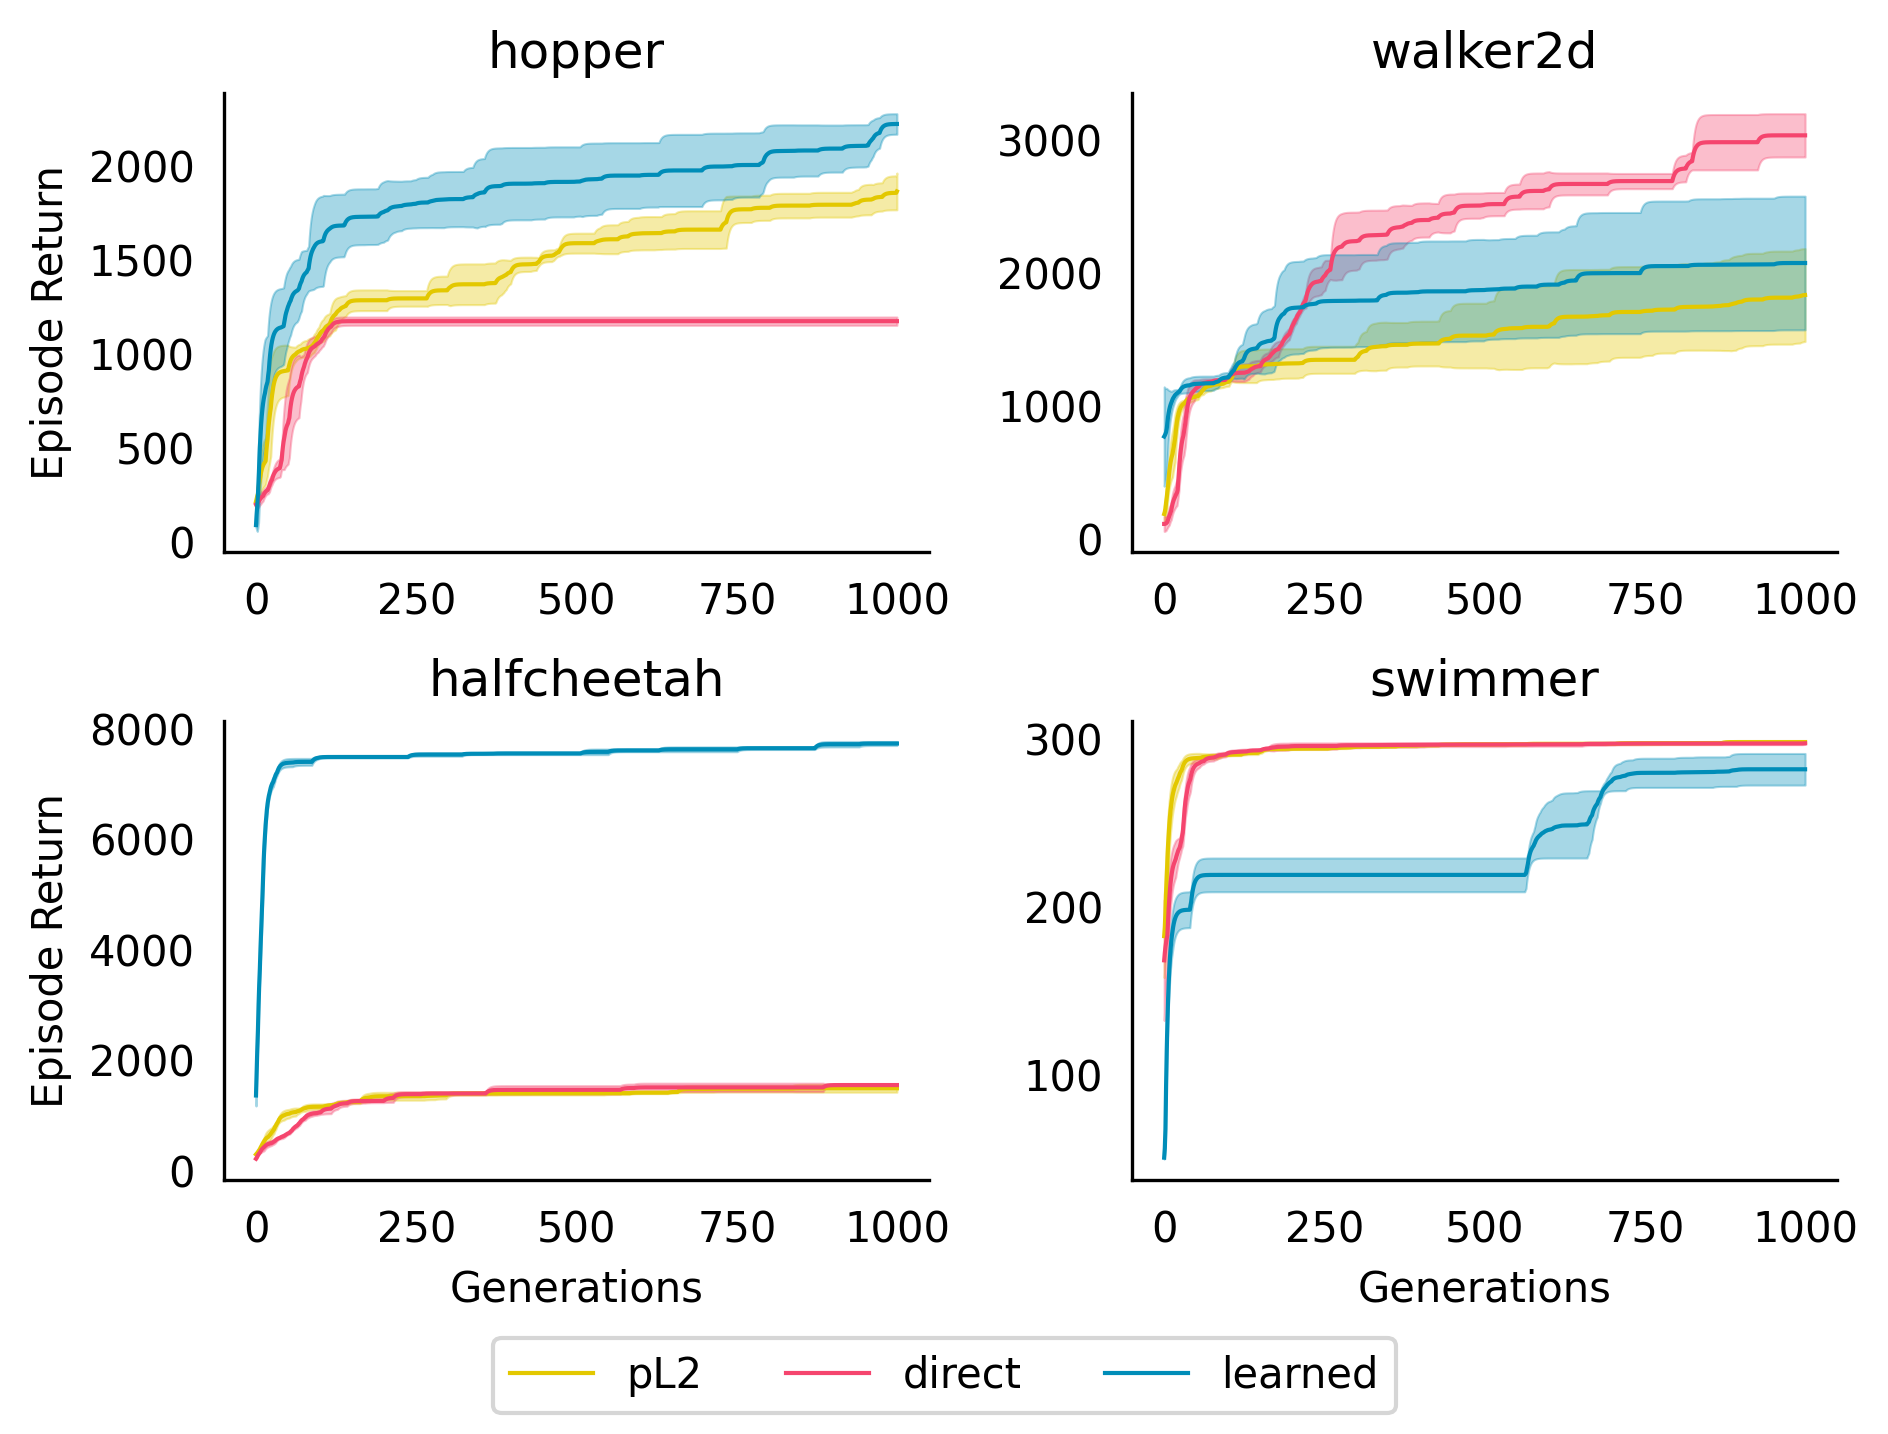

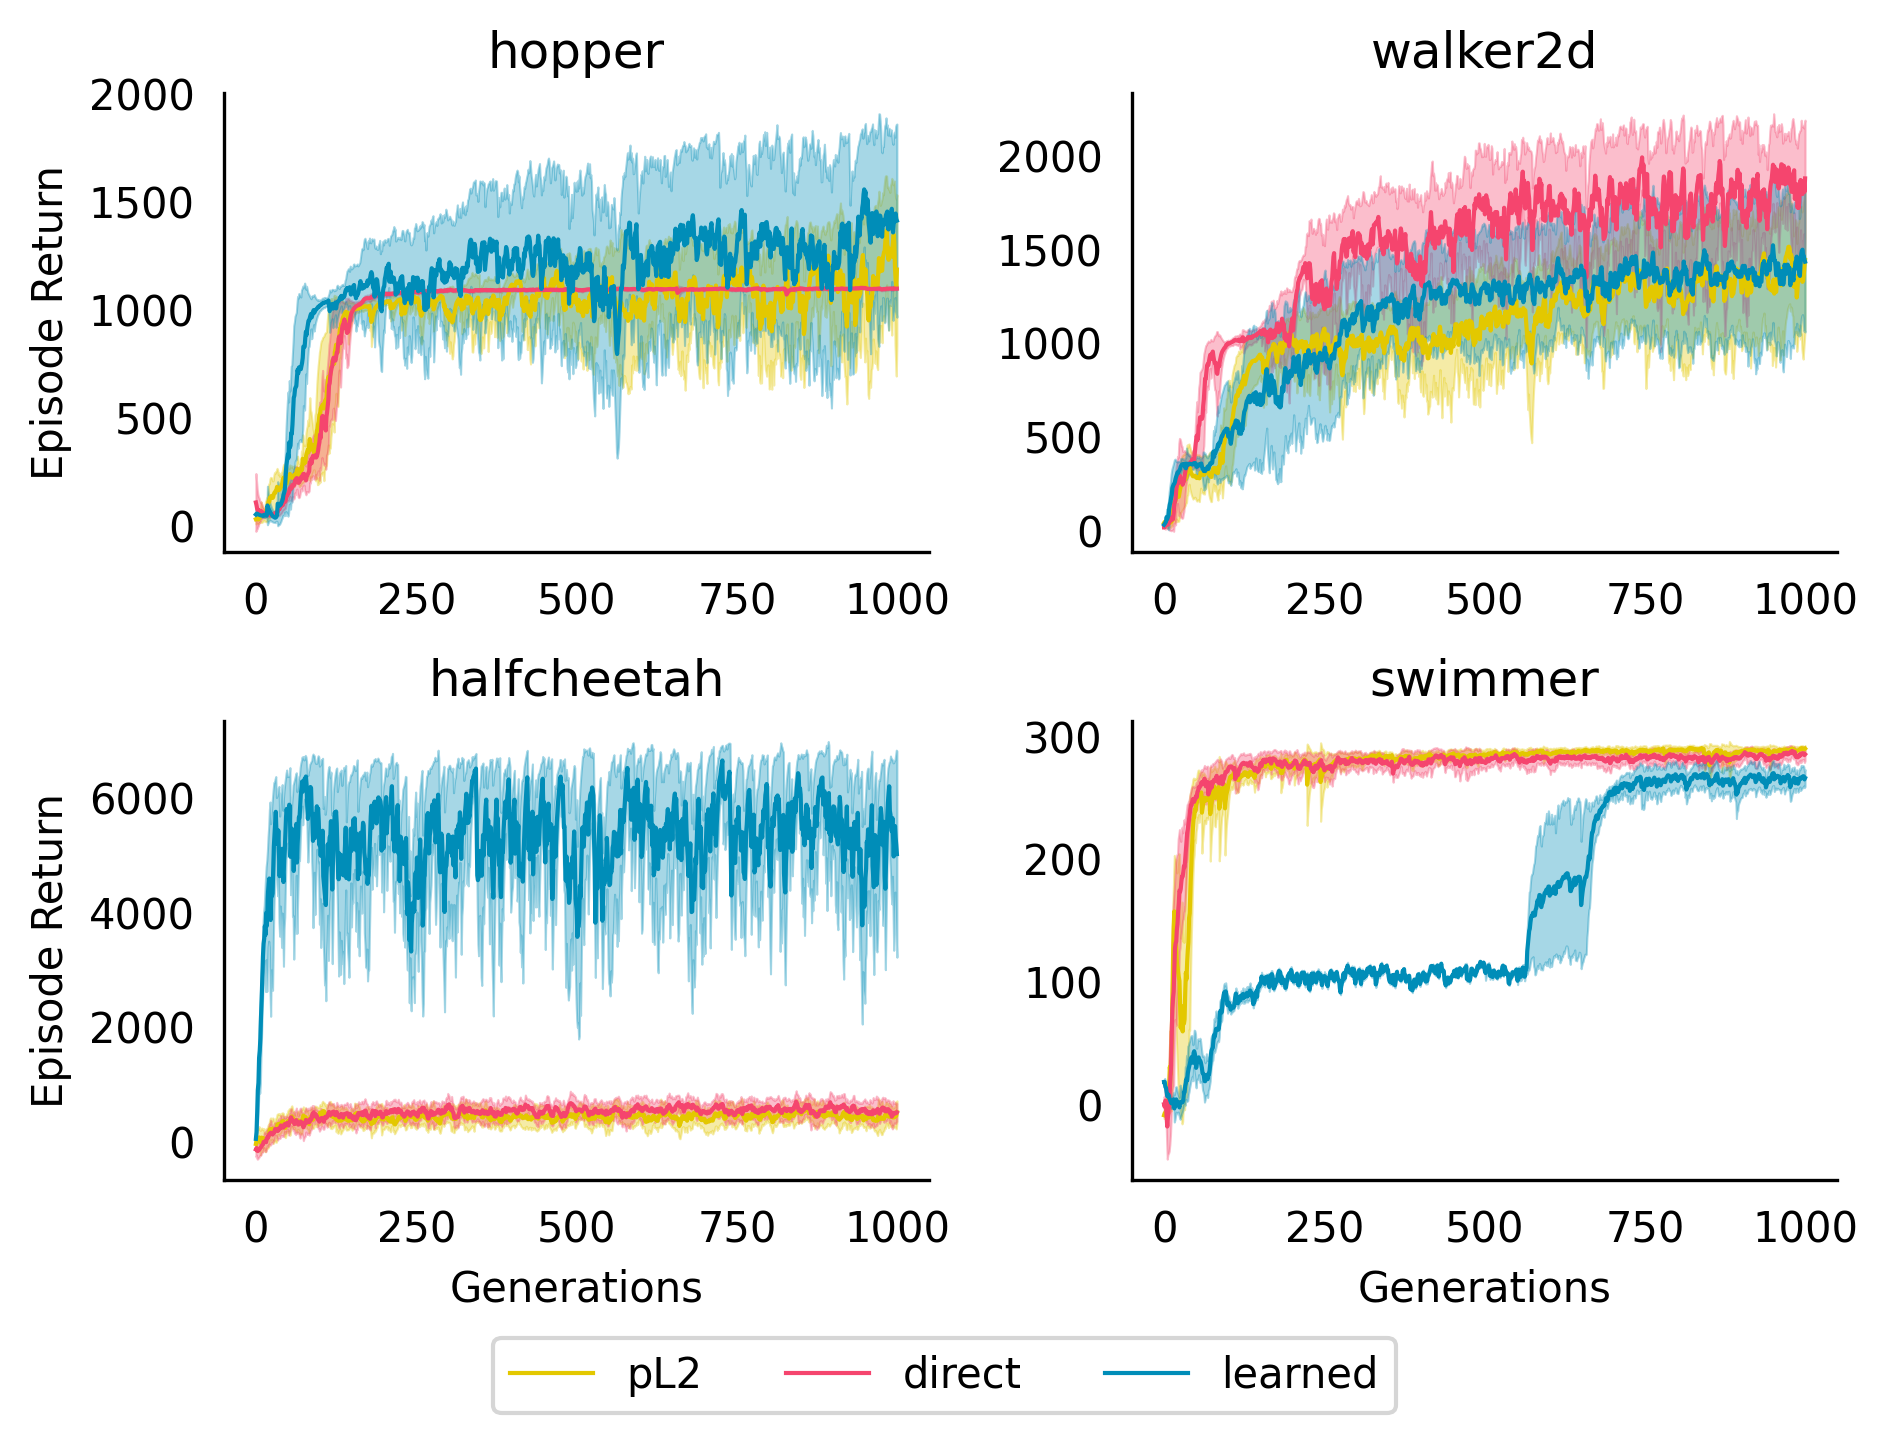

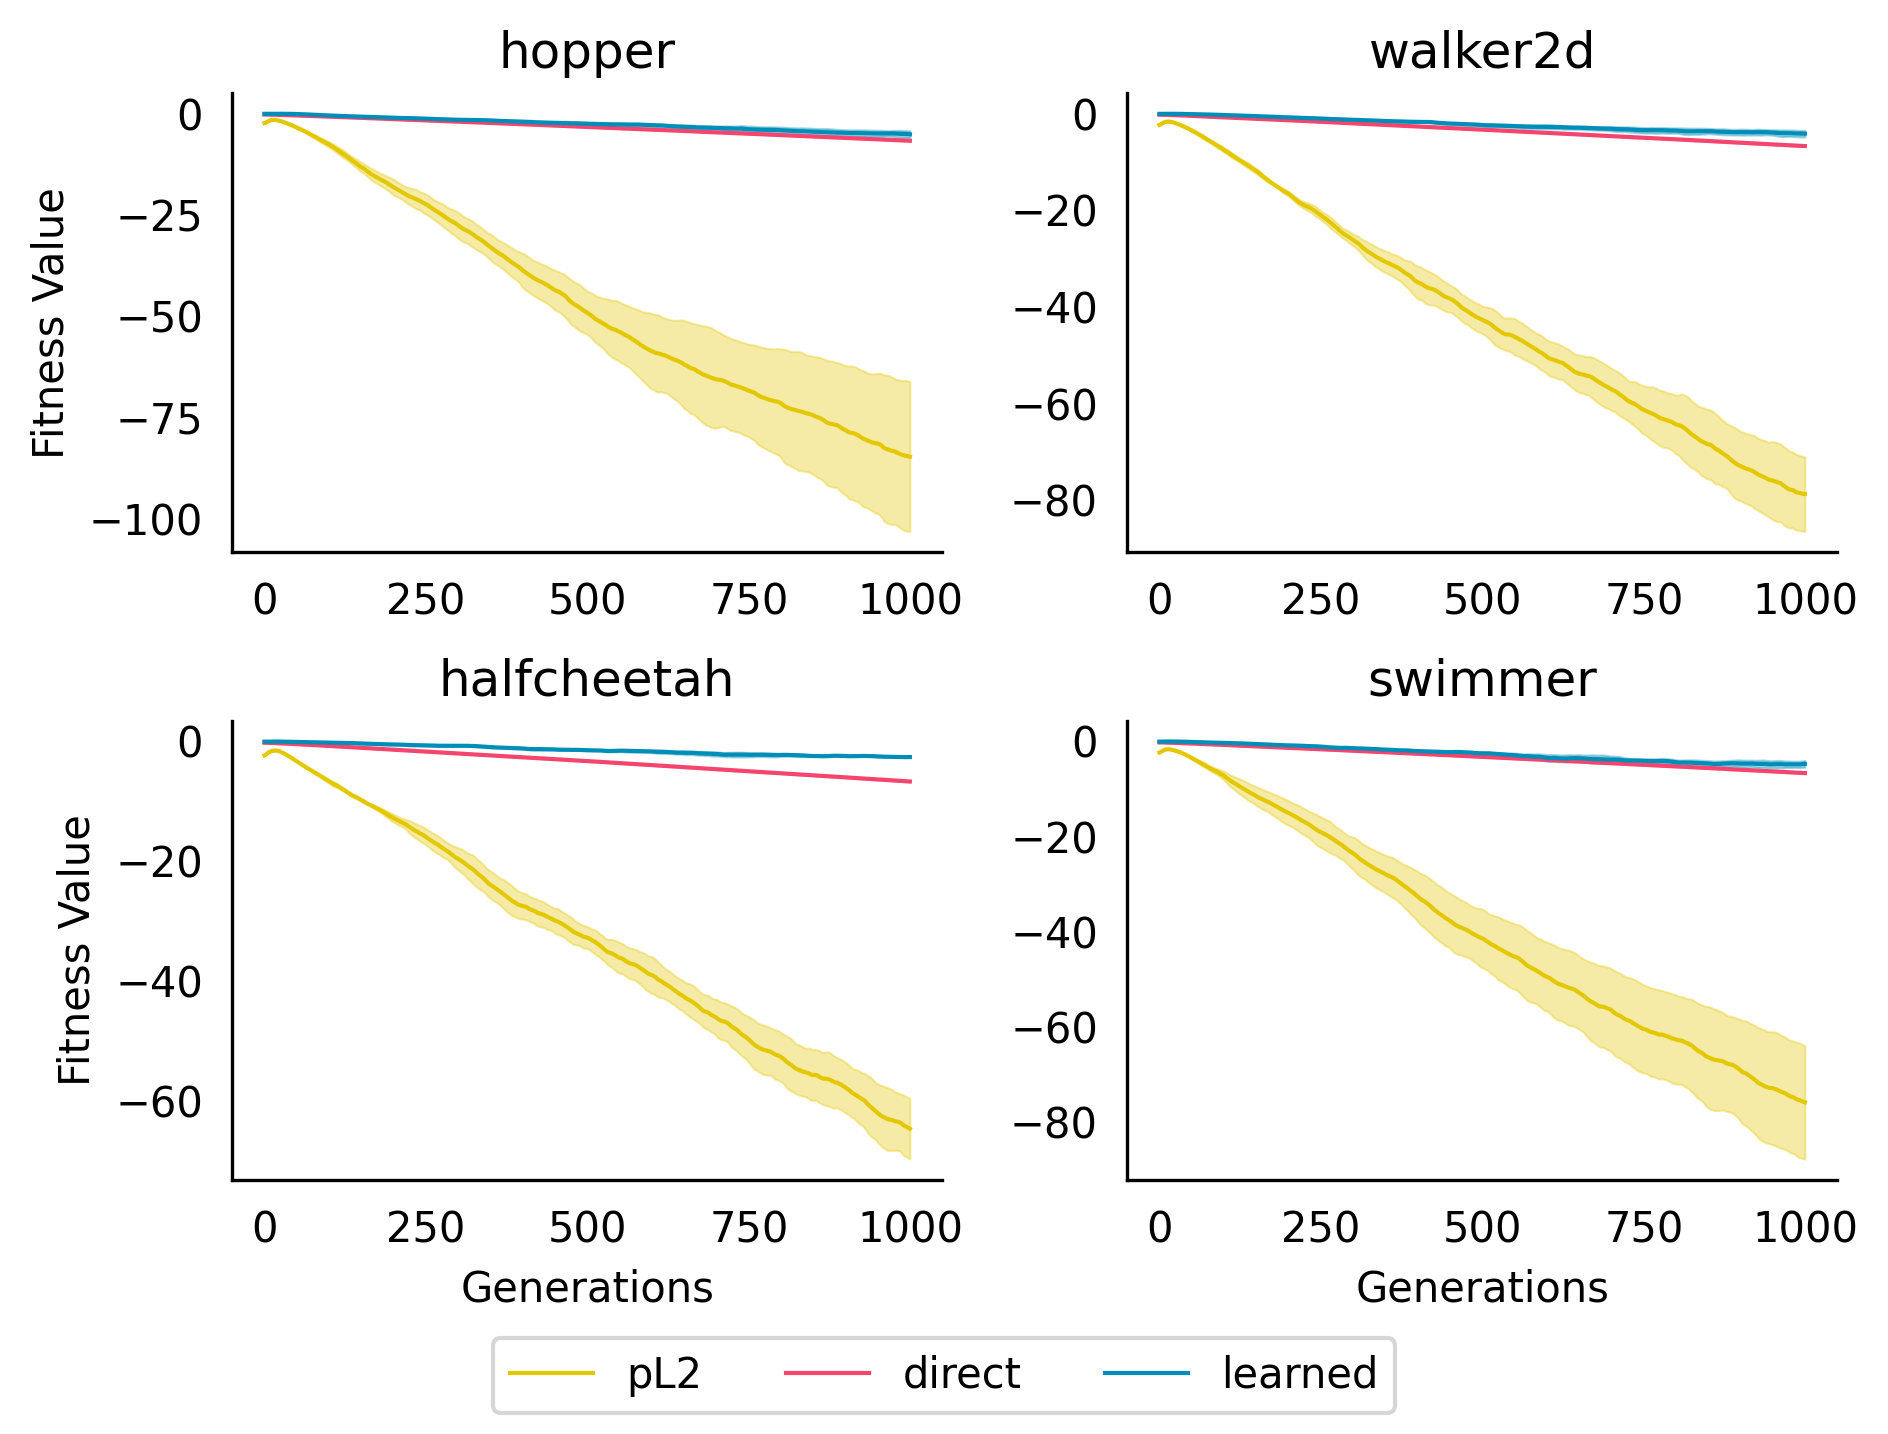

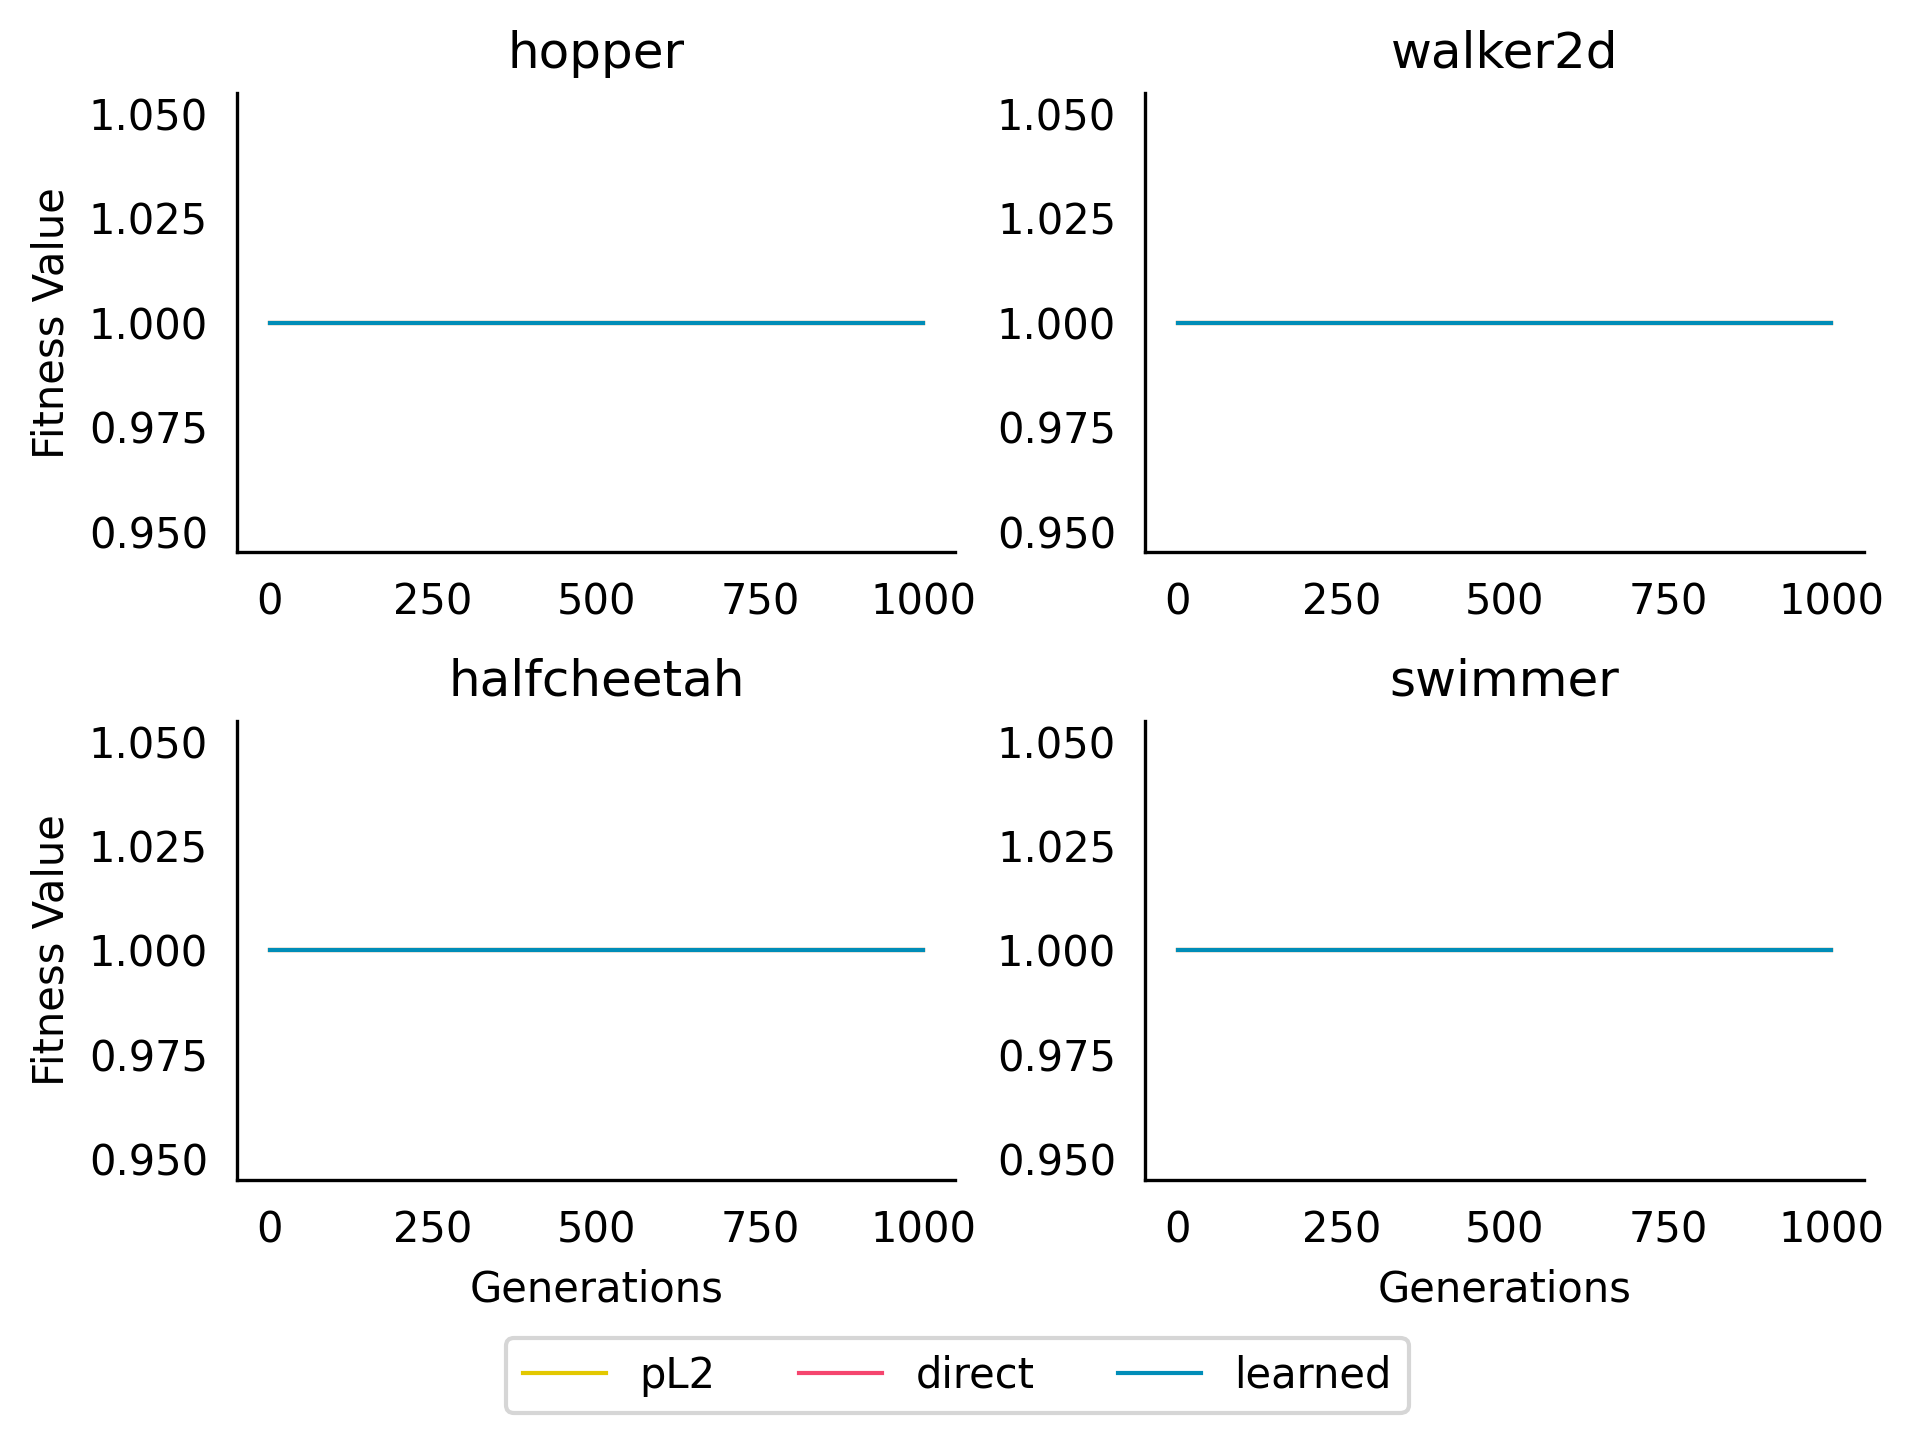

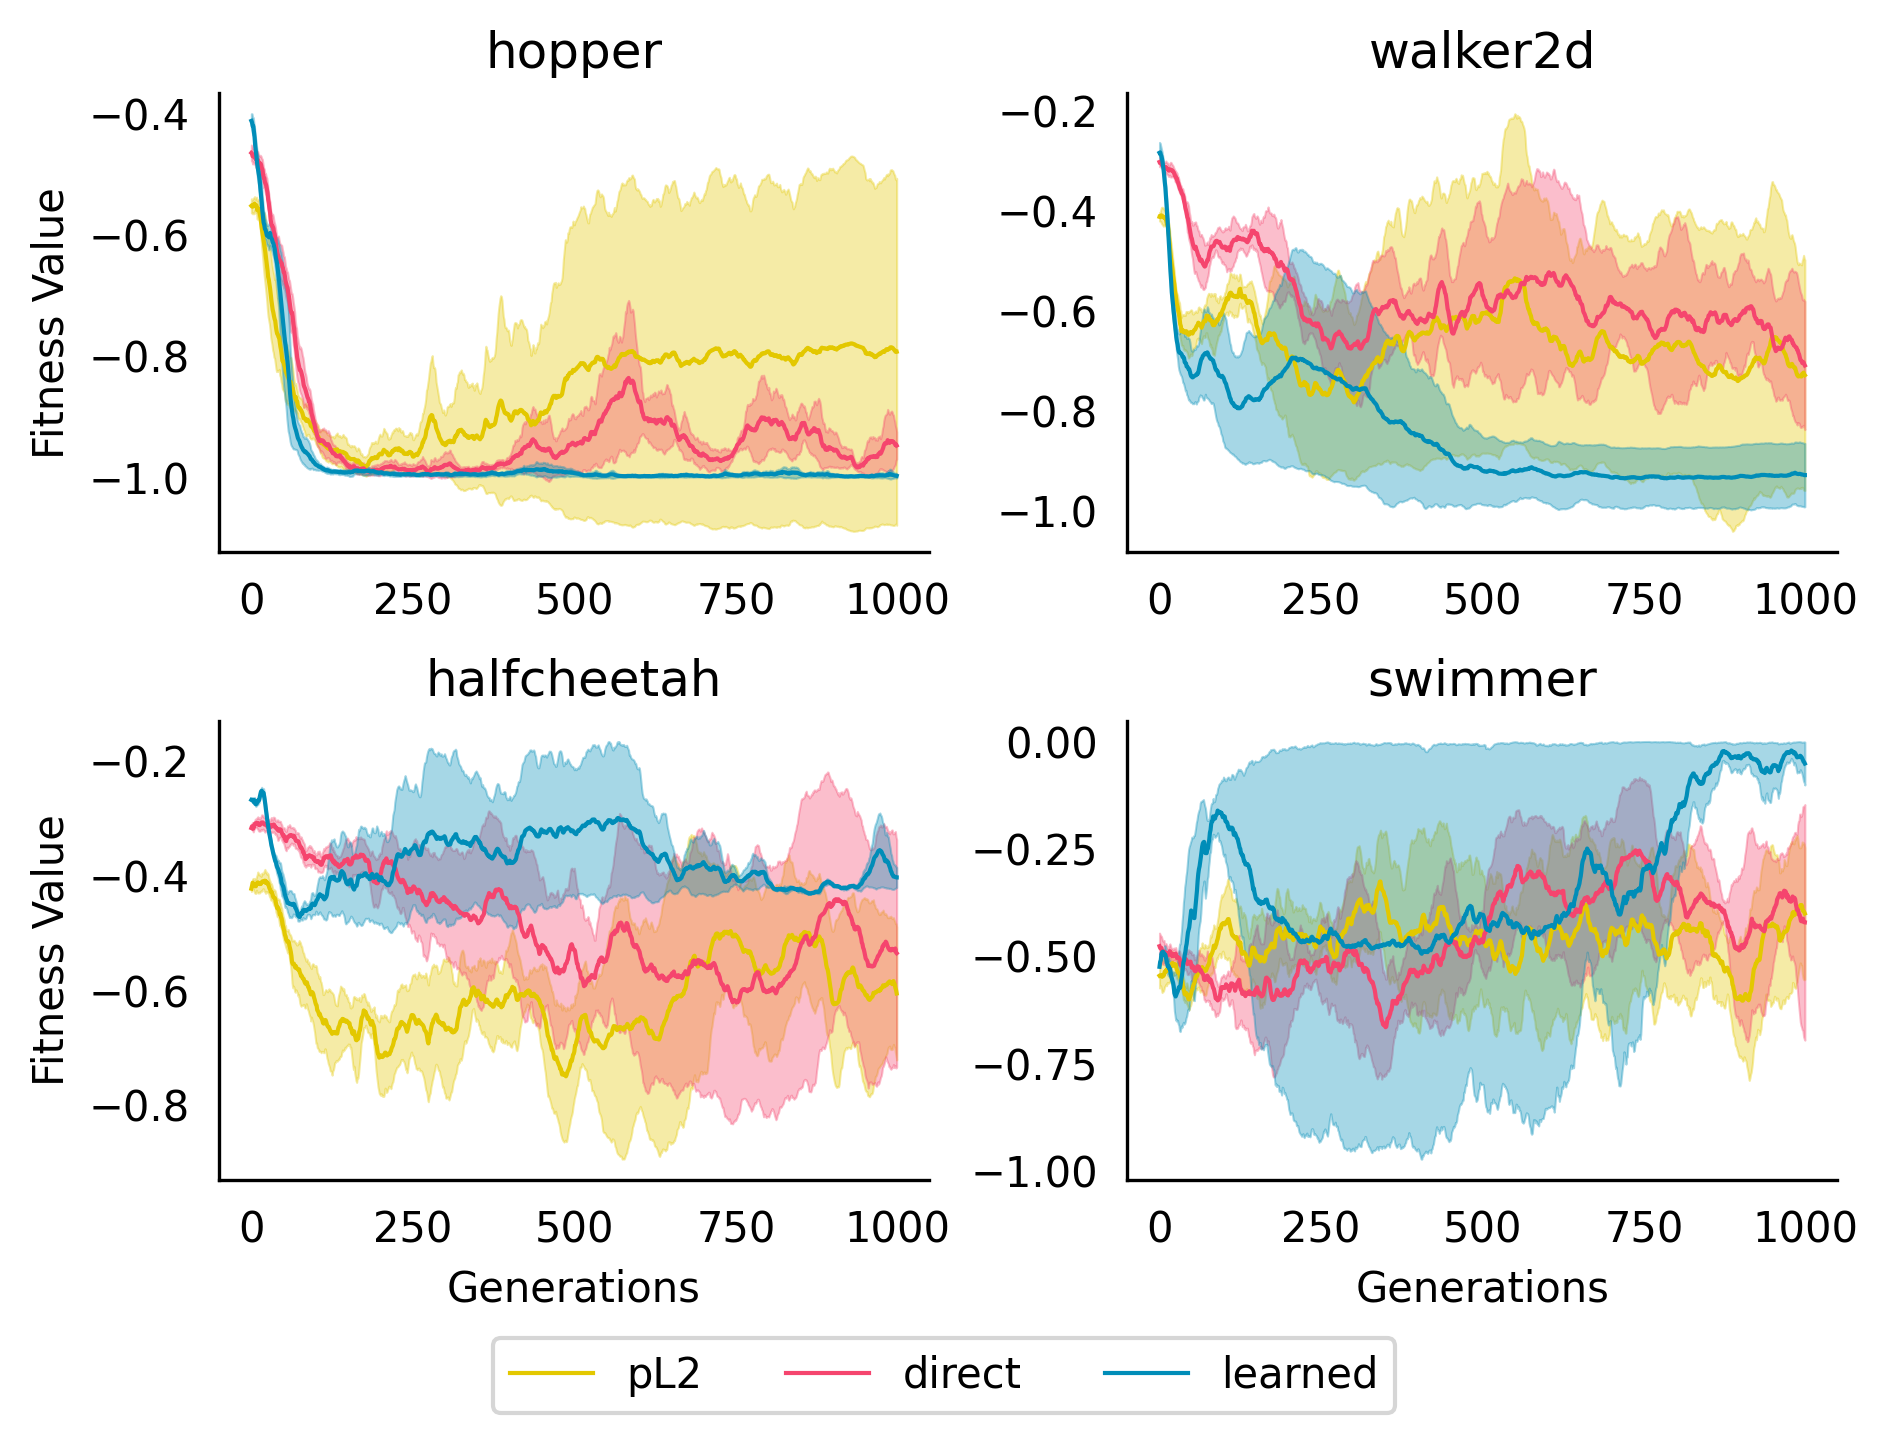

In [233]:
def fill_between(ax, x, y, eps, linewidth: float, color: str):
    ax.fill_between(
        x, 
        y - eps, 
        y + eps, 
        color=color, 
        alpha=0.35,
        linewidth=linewidth,
    )
def fig_legend(fig, loc:str="lower center", ncol:int=4, **kwdargs):
        """https://stackoverflow.com/a/57484812"""
        tuples_lohand_lolbl = [ax.get_legend_handles_labels() for ax in fig.axes]
        # Only one legend is taken and plotted since they are all the same
        tuples_lohand_lolbl = tuples_lohand_lolbl[0]
        tolohs = zip(tuples_lohand_lolbl)
        handles, labels = (sum(list_of_lists, []) for list_of_lists in tolohs)
        return fig.legend(handles, labels, loc=loc, ncol=ncol, **kwdargs)

def ema(x, alpha=0.2):
    """Exponential mooving average smoothing"""
    s_t = x[0]
    for i, x_t in enumerate(x[1:]):
        s_t = alpha * x_t + (1 - alpha) * s_t
        x[i + 1] = s_t
    return x

def comparison_plot(
        data,
        metric: str,
        title: str = "[Metric] on 4 environnments",
        filename: str = "test.png",
        dpi: int = 300,
        linewidth: float = 1,
        e_bars_linewidth: float = 0.5,
        xlabel: str = "Generations",
        ylabel: str = "Episode Return",
        apply_smoothing: bool = False
        ):
    fig, axs = plt.subplots(2, 2)
    fig.set_dpi(dpi)

    colors = {
        # https://www.simplifiedsciencepublishing.com/resources/best-color-palettes-for-scientific-figures-and-data-visualizations
        # "pL2": "#f47a00",
        # "direct": "#007191",
        # "learned": "#d31f11",

        # NOTE - pastel gris violet
        # "pL2": "#AB004A",
        # "direct": "#948784", # #BAB4A9
        # "learned": "#FFCCBB",

        # NOTE - Ponyo
        # "pL2": "#e3c800",
        # "direct": "#f5456e",
        # "learned": "#008db8",

        # BPC
        # "pL2": "#303030",
        # "direct": "#528484",
        # "learned": "#ffc0cb",

        # NOTE - https://github.com/OrdnanceSurvey/GeoDataViz-Toolkit/blob/master/Colours/GDV%20colour%20palettes%200.6.pdf
        # "pL2": "#FFAA00",
        # "direct": "#00B000",
        # "learned": "#E9002D",
        # Close to ponyo
        "pL2": "#009ADE",
        "direct": "#FFC61E",
        "learned": "#FF1F5B",

    }

    x = np.arange(0, 1000)
    for env, ax in zip(["hopper", "walker2d", "halfcheetah", "swimmer"], axs.flat):
        ax.set_title(env)
        ax.spines[['right', 'top']].set_visible(False)

        # NOTE - Get data
        ag_data_pL2 = np.array(aggregate_multiple_runs(data, env, "pL2")[metric])
        ag_data_direct = np.array(aggregate_multiple_runs(data, env, "direct")[metric])
        # FIXME
        if env in ["halfcheetah", "swimmer"]:
            fix_agg_hc = []
            for l in aggregate_multiple_runs(data, env, "learned")[metric]:
                if (len(l)) == 1000:
                    fix_agg_hc.append(l) 
            ag_data_learned = np.array(fix_agg_hc)
        else:
                
            # FIXME
            ag_data_learned = np.array(
                aggregate_multiple_runs(data, env, "learned")[metric]
            )

        F = lambda e: e
        if apply_smoothing:
            F = lambda e: ema(e)

        y_pl2 = F(ag_data_pL2.mean(axis=0))
        y_direct = F(ag_data_direct.mean(axis=0))
        y_learned = F(ag_data_learned.mean(axis=0))

        eps_pl2 = F(ag_data_pL2.std(axis=0))
        eps_direct = F(ag_data_direct.std(axis=0))
        eps_learned = F(ag_data_learned.std(axis=0))

        ax.plot(x, y_pl2, color=colors["pL2"], label="pL2", linewidth=linewidth)
        ax.plot(x, y_direct, color=colors["direct"], label="direct", linewidth=linewidth)
        ax.plot(x, y_learned, color=colors["learned"], label="learned", linewidth=linewidth)

        fill_between(ax, x, y_pl2, eps_pl2, e_bars_linewidth, colors["pL2"])
        fill_between(ax, x, y_direct, eps_direct, e_bars_linewidth, colors["direct"])
        fill_between(ax, x, y_learned, eps_learned, e_bars_linewidth, colors["learned"])
    
    fig_legend(
        fig,
        loc="lower center",
        ncol=4,
        # borderaxespad=-1,
        # bbox_to_anchor = (0.5, -0.1),
    )


    # NOTE - Handle ticks, 
    for i, ax in enumerate(axs.flat):
        if i in [0, 2]:
            ax.set_ylabel(ylabel)
        if i in [2, 3]:
            ax.set_xlabel(xlabel)
        ax.tick_params(
            top=False,
            bottom=False,
            left=False,
            right=False,
        )
        

    # fig.suptitle(title)
    fig.tight_layout() # h_pad=1
    fig.subplots_adjust(bottom=0.17)
        
    plt.savefig(filename, dpi=dpi)
    plt.show()



for metric in [
    "training.top_k_fit.top_0_fit",
    "eval.mean_fit",
    # NN properties
    "training.net_prop.f_weight_distribution",
    "training.net_prop.f_expressivity",
    "training.net_prop.f_input_restoration",]:

    if "net_prop" in metric:
        ylabel = "Fitness Value"
    else:
        ylabel = "Episode Return"
    comparison_plot(
        data, 
        metric=metric, 
        filename="figures/" + metric.split('.')[-1] + ".png",
        ylabel=ylabel,
        apply_smoothing=True,
        )

---

# Produce / Get Meta Evolution Plots

In [ ]:
def get_meta_evol(entity: str, project: str, run: str):
    run = wandb.Api().run(f"{entity}/{project}/{run}")

    metrics_to_get = [
        "training.top_k_fit.top_0_fit",
        "eval.mean_fit",
        # NN properties
        "training.net_prop.f_weight_distribution",
        "training.net_prop.f_expressivity",
        "training.net_prop.f_input_restoration",
    ]
    